In [363]:
%reset -f
%load_ext autoreload
%autoreload 2

import sys
import os

sys.path.append(os.path.join(os.path.pardir, 'code'))

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

import figure_functions as ff

from mpc_fly import MpcFlyWind

import utils

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
import visualkeras

pd.set_option('display.max_columns', None)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [364]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4254074454643797013
 xla_global_id: -1]

In [365]:
tf.config.list_physical_devices('GPU')

[]

# Load data

In [366]:
data_path = os.path.join(os.path.pardir, 'data', 'trajectory_data.csv')
data_path

'..\\data\\trajectory_data.csv'

In [367]:
data = pd.read_csv(data_path)
data

,Unnamed: 0,time,v_para,v_perp,phi,phidot,w,zeta,I,m,C_para,C_perp,C_phi,d,km1,km2,km3,km4,ks1,ks2,ks3,ks4,ks5,ks6,ks7,g,psi,of,a_para,a_perp,a,gamma,v_para_dot,v_perp_dot,v_para_dot_uncal,v_perp_dot_uncal,phiddot,q,alpha,dir_of_travel,xvel,yvel,xpos,ypos,u_para,u_perp,u_phi,wdot,zetadot,u_g,u_psi,phi_uncal,gamma_uncal,psi_uncal,alpha_uncal,phi_y,phi_x,psi_y,psi_x,gamma_y,gamma_x,alpha_y,alpha_x,zeta_x,zeta_y,phi_uncal_y,phi_uncal_x,psi_uncal_y,psi_uncal_x,gamma_uncal_y,gamma_uncal_x,alpha_uncal_y,alpha_uncal_x
0,0,0.00,0.500000,0.000000,0.000000,0.000000,0.100000,0.000000,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,0.000000,1.666667,0.400000,0.000000,0.400000,0.000000,-0.001556,0.000000,-0.001556,0.000000,0.000000,0.001556,3.141593,0.000000,0.500000,0.000000,0.000000,0.000000,0.587846,0.000000,0.000000,0.000067,0.000000,0.587846,0.000000,0.000000,0.000000,0.000000,3.141593,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.224647e-16,-1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.224647e-16,-1.000000
1,1,0.01,0.499985,0.000000,0.000000,0.000000,0.100001,0.000000,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.499985,0.000000,1.666616,0.399984,0.000000,0.399984,0.000000,-0.001463,0.000000,-0.001463,0.000000,0.000000,0.001463,3.141593,0.000000,0.499985,0.000000,0.005000,0.000000,0.587846,0.000000,0.000000,0.000067,0.000000,0.587846,0.000000,0.000000,0.000000,0.000000,3.141593,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.224647e-16,-1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.224647e-16,-1.000000
2,2,0.02,0.500000,0.000000,0.000000,0.000000,0.100000,0.000000,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,0.000000,1.666666,0.400000,0.000000,0.400000,0.000000,0.001457,0.000000,0.001457,0.000000,0.000000,0.001457,0.000000,0.000000,0.500000,0.000000,0.010000,0.000000,0.588599,0.000000,0.000000,-0.000055,0.000000,0.588599,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.000000e+00,1.000000
3,3,0.03,0.500000,0.000000,0.000000,0.000000,0.100000,0.000000,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,0.000000,1.666667,0.400000,0.000000,0.400000,0.000000,0.000008,0.000000,0.000008,0.000000,0.000000,0.000008,0.000000,0.000000,0.500000,0.000000,0.015000,0.000000,0.588237,0.000000,0.000000,-0.000014,0.000000,0.588237,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.000000e+00,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,0.000000e+00,1.000000
4,4,0.04,0.500000,0.000000,0.000000,0.000000,0.100000,0.000000,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.500000,0.000000,1.666667,0.400000,0.000000,0.400000,0.000000,-0.000001,0.000000,-0.000001,0.000000,0.000000,0.000001,3.141593,0.000000,0.500000,0.000000,0.020000,0.000000,0.588235,0.000000,0.000000,-0.000003,0.000000,0.588235,0.000000,0.000000,0.000000,0.000000,3.141593,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.224647e-16,-1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.000000,1.000000,1.224647e-16,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32635,46,0.46,0.499959,-0.000028,-2.947734,69.194578,9.999990,6.086827,0.52,0.25,1.470588,1.470588,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.499959,-0.000055,1.666530,9.748216,-3.803914,10.464104,5.911141,5.377394,18.466421,5.377394,18.466421,257.640999,19.233436,1.287434,-2.947789,

In [368]:
data['phi'] = utils.wrapToPi(data['phi'])
data['psi'] = utils.wrapToPi(data['psi'])
data['gamma'] = utils.wrapToPi(data['gamma'])
data['alpha'] = utils.wrapToPi(data['alpha'])

# Pull out data

In [369]:
# Input variables
input_names =  ['phi', 'gamma']
# input_names =  ['phi_x', 'phi_y', 'gamma_x', 'gamma_y']

In [370]:
# Output variables to predict
output_names =  ['zeta_x', 'zeta_y']

In [371]:
Z = data.loc[:, ['time'] + input_names + output_names]
Z

,time,phi,gamma,zeta_x,zeta_y
0,0.00,0.000000,0.000000,1.000000,0.000000
1,0.01,0.000000,0.000000,1.000000,0.000000
2,0.02,0.000000,0.000000,1.000000,0.000000
3,0.03,0.000000,0.000000,1.000000,0.000000
4,0.04,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...
32635,0.46,-2.947734,-0.372044,0.980784,-0.195099
32636,0.47,-2.259383,-1.035542,0.980786,-0.195088
32637,0.48,-1.602536,-1.685705,0.980788,-0.195075
32638,0.49,-1.021496,-2.278419,0.980790,-0.195066


In [372]:
n_point = Z.shape[0]
n_point

32640

# Separate individual trajectories

In [373]:
startI = np.where(Z.time.values == 0.0)[0]
n_traj = startI.shape[0]
n_traj

640

In [374]:
Z_list = []
# startI = np.where(Z.time.values == 0.0)[0] # find start of seperate trajectories
for n in range(n_traj):
    if n == (n_traj - 1):
        endI = Z.shape[0]
    else:
        endI = (startI[n + 1])

    traj = Z.iloc[startI[n]:endI, :]
    Z_list.append(traj)

In [375]:
len(Z_list) * 51

32640

In [376]:
# Z_test = pd.concat(Z_list)
# np.all(Z_test.values == Z.values)

# Augment training data with prior time-steps

In [377]:
window_size = 4 

In [378]:
Zaug = []
for z in Z_list:
    zaug = utils.collect_offset_rows(z, aug_column_names=input_names,
                                     keep_column_names=output_names,
                                     w=window_size,
                                     direction='backward')
    Zaug.append(zaug)

Zaug = pd.concat(Zaug, ignore_index=True)

In [379]:
Zaug.shape

(30720, 10)

In [380]:
Zaug

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3,zeta_x,zeta_y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
30715,-2.947734,2.658979,2.030259,1.474201,-0.372044,0.272777,0.876531,1.421560,0.980784,-0.195099
30716,-2.259383,-2.947734,2.658979,2.030259,-1.035542,-0.372044,0.272777,0.876531,0.980786,-0.195088
30717,-1.602536,-2.259383,-2.947734,2.658979,-1.685705,-1.035542,-0.372044,0.272777,0.980788,-0.195075
30718,-1.021496,-1.602536,-2.259383,-2.947734,-2.278419,-1.685705,-1.035542,-0.372044,0.980790,-0.195066


# Save augmented data

In [381]:
save_path = os.path.join(os.path.pardir, 'data', 'trajectory_data_augmented.csv')
Zaug.to_csv(path_or_buf=save_path)

In [382]:
# Reload
Zaug = pd.read_csv(save_path)
Zaug = Zaug.iloc[:, 1:]
Zaug

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3,zeta_x,zeta_y
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
30715,-2.947734,2.658979,2.030259,1.474201,-0.372044,0.272777,0.876531,1.421560,0.980784,-0.195099
30716,-2.259383,-2.947734,2.658979,2.030259,-1.035542,-0.372044,0.272777,0.876531,0.980786,-0.195088
30717,-1.602536,-2.259383,-2.947734,2.658979,-1.685705,-1.035542,-0.372044,0.272777,0.980788,-0.195075
30718,-1.021496,-1.602536,-2.259383,-2.947734,-2.278419,-1.685705,-1.035542,-0.372044,0.980790,-0.195066


# Pull out training data

In [383]:
n_input = len(input_names) * window_size
n_output = len(output_names)

print('Inputs:', n_input)
print('Output:', n_output)

Inputs: 8
Output: 2


In [384]:
# Input data
X = Zaug.iloc[:, 0:n_input]
X

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...
30715,-2.947734,2.658979,2.030259,1.474201,-0.372044,0.272777,0.876531,1.421560
30716,-2.259383,-2.947734,2.658979,2.030259,-1.035542,-0.372044,0.272777,0.876531
30717,-1.602536,-2.259383,-2.947734,2.658979,-1.685705,-1.035542,-0.372044,0.272777
30718,-1.021496,-1.602536,-2.259383,-2.947734,-2.278419,-1.685705,-1.035542,-0.372044


In [385]:
# Output data
Y = Zaug.iloc[:, n_input:]
Y

,zeta_x,zeta_y
0,1.000000,0.000000
1,1.000000,0.000000
2,1.000000,0.000000
3,1.000000,0.000000
4,1.000000,0.000000
...,...,...
30715,0.980784,-0.195099
30716,0.980786,-0.195088
30717,0.980788,-0.195075
30718,0.980790,-0.195066


# Construct model

In [386]:
model = Sequential()
model.add(Dense(50, input_dim=n_input, activation='relu'))
model.add(Dense(50, input_dim=n_input, activation='relu'))
model.add(Dense(20, input_dim=n_input, activation='relu'))
# model.add(Dense(50, input_dim=n_input, activation='relu'))
model.add(Dense(n_output, activation='linear'))

In [387]:
from keras import backend as K

In [388]:
def custom_loss(y_true, y_pred):
    mse = tf.square(y_true - y_pred)
    # delta = 0.01
    # sin_cos_constraint = 1 - K.sqrt( K.square(y_pred[0]) - K.square(y_pred[1]) )
    # loss = mse + delta*sin_cos_constraint
    # K.square(y_pred[0] - y_true[0])
    
    loss = mse + 0.000001*(1 - K.sqrt(K.square(y_pred[0]) + K.square(y_pred[1])))
    # loss = mse
    return loss

In [389]:
model.compile(loss='mse', optimizer='adam', metrics=['mae'])
# model.compile(loss=custom_loss, optimizer='adam', metrics=['mae'])

In [390]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 50)                450       
                                                                 
 dense_25 (Dense)            (None, 50)                2550      
                                                                 
 dense_26 (Dense)            (None, 20)                1020      
                                                                 
 dense_27 (Dense)            (None, 2)                 42        
                                                                 
Total params: 4062 (15.87 KB)
Trainable params: 4062 (15.87 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [391]:
visualkeras.layered_view(model)

In [392]:
Y.shape

(30720, 2)

# Train model

In [393]:
model.fit(X, Y, epochs=150, batch_size=200, verbose=1)

Epoch 1/150
154/154 [==============================] - 1s 2ms/step - loss: 0.3226 - mae: 0.4744
Epoch 2/150
154/154 [==============================] - 0s 2ms/step - loss: 0.1990 - mae: 0.3455
Epoch 3/150
154/154 [==============================] - 0s 2ms/step - loss: 0.1726 - mae: 0.3164
Epoch 4/150
154/154 [==============================] - 0s 2ms/step - loss: 0.1587 - mae: 0.2995
Epoch 5/150
154/154 [==============================] - 0s 1ms/step - loss: 0.1493 - mae: 0.2878
Epoch 6/150
154/154 [==============================] - 0s 2ms/step - loss: 0.1423 - mae: 0.2791
Epoch 7/150
154/154 [==============================] - 0s 2ms/step - loss: 0.1354 - mae: 0.2698
Epoch 8/150
154/154 [==============================] - 0s 1ms/step - loss: 0.1302 - mae: 0.2632
Epoch 9/150
154/154 [==============================] - 0s 1ms/step - loss: 0.1253 - mae: 0.2572
Epoch 10/150
154/154 [==============================] - 0s 1ms/step - loss: 0.1208 - mae: 0.2517
Epoch 11/150
154/154 [=================

# Run model on training data

In [394]:
Y_train = model.predict(X, batch_size=5000)
Y_train.shape

7/7 [==============================] - 0s 5ms/step


(30720, 2)

In [395]:
# plt.plot(Y_train[:, 0], 'b.', markersize=1, alpha=0.1)
# plt.plot(Y.values[:, 0], 'k.', markersize=1)

In [396]:
# plt.plot(Y_train[:, 1], 'r.', markersize=1, alpha=0.1)
# plt.plot(Y.values[:, 1], 'k.', markersize=1)

In [397]:
zeta_train = np.arctan2(Y_train[:, 1], Y_train[:, 0])
zeta_true = np.arctan2(Y.values[:, 1], Y.values[:, 0])

Text(0.5, 0, 'True wind direction (rad)')

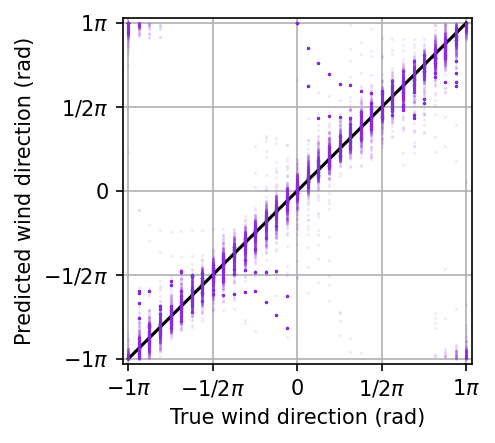

In [398]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

zeta_line = np.arange(-np.pi, 1.01*np.pi, np.pi/2)

ax.plot(zeta_line, zeta_line, '-', color='black')
ax.plot(zeta_true, zeta_train, '.', markersize=1, alpha=0.1, color='blueviolet')

ff.pi_yaxis(ax)
ff.pi_xaxis(ax)
ax.grid()

ax.set_ylim(-np.pi - 0.1, np.pi + 0.1)
ax.set_xlim(-np.pi - 0.1, np.pi + 0.1)

ax.set_ylabel('Predicted wind direction (rad)')
ax.set_xlabel('True wind direction (rad)')

# Save model

In [399]:
save_nn_path = os.path.join(os.path.pardir, 'data', 'network_trained.keras')
save_nn_path

'..\\data\\network_trained.keras'

In [400]:
model.save(save_nn_path)

# Reload model

In [401]:
model_load = keras.models.load_model(save_nn_path)

# Test model on new data

## Set trajectory

In [402]:
fs = 100.0
dt = 1/fs
T = 0.5
n_point = int((T * fs) + 1)
tsim = dt * (np.linspace(1.0, n_point, n_point) - 1)

In [403]:
v_para = 0.5 * np.ones_like(tsim)
v_perp = 0.0 * np.ones_like(tsim)
phi = 0.2*np.pi + np.pi * np.sin(2*np.pi*2.0*tsim)
w = 20.20 * np.ones_like(tsim)
zeta = (np.pi/3) * np.ones_like(tsim)

# zeta = 0.0*np.pi + np.pi * np.sin(2*np.pi*1.0*tsim)
# v_para = 0.5 + 0.2 * np.sin(2*np.pi*3.3*tsim)
# phi = (np.pi/5)* np.ones_like(tsim)
# phi[0:20:] = phi[0] + np.pi/2

# w = 7.0 + 1.2*np.sin(2*np.pi*2.0*tsim)


## Simulate trajectory 

In [404]:
mpc = MpcFlyWind(v_para, v_perp, phi, w, zeta, x0=None, dt=dt, n_horizon=20, r_weight=1e-6)

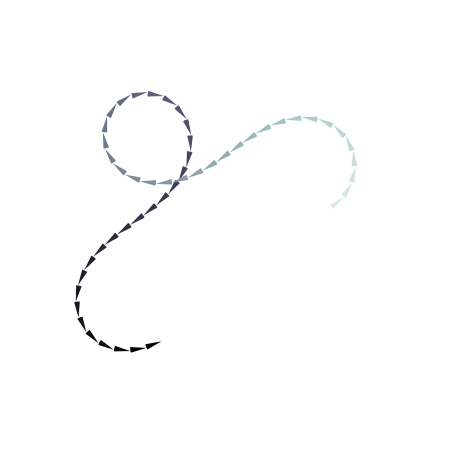

In [405]:
mpc.plot_trajectory(cmap=None, size=5, dpi=100, arrow_size=0.005, nskip=0)

In [406]:
data = mpc.sim_data_df
np.round(data, 5)

,time,v_para,v_perp,phi,phidot,w,zeta,I,m,C_para,C_perp,C_phi,d,km1,km2,km3,km4,ks1,ks2,ks3,ks4,ks5,ks6,ks7,g,psi,of,a_para,a_perp,a,gamma,v_para_dot,v_perp_dot,v_para_dot_uncal,v_perp_dot_uncal,phiddot,q,alpha,dir_of_travel,xvel,yvel,xpos,ypos,u_para,u_perp,u_phi,wdot,zetadot,u_g,u_psi,phi_uncal,gamma_uncal,psi_uncal,alpha_uncal,phi_y,phi_x,psi_y,psi_x,gamma_y,gamma_x,alpha_y,alpha_x,zeta_x,zeta_y,phi_uncal_y,phi_uncal_x,psi_uncal_y,psi_uncal_x,gamma_uncal_y,gamma_uncal_x,alpha_uncal_y,alpha_uncal_x
0,0.00,0.50000,0.00000,0.62832,39.68508,20.20000,1.04720,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,0.00000,1.66667,-17.95362,-8.21608,19.74427,-2.71241,-7.46226,18.51919,-7.46226,18.51919,-1022.64877,19.96612,1.95384,0.62832,0.40451,0.29389,0.00000,0.00000,-28.26795,-2.49204,554.00635,-0.00243,-0.00838,28.37758,-3.05366,0.62832,-2.71241,0.00000,1.95384,0.58779,0.80902,0.00000,1.0,-0.41612,-0.90931,0.92753,-0.37375,0.50000,0.86603,0.58779,0.80902,0.00000,1.0,-0.41612,-0.90931,0.92753,-0.37375
1,0.01,0.50068,0.00017,0.98194,31.73316,20.19998,1.04711,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50068,0.00034,1.66893,-19.65641,-1.31542,19.70038,-3.07477,2.55962,-18.11846,2.55962,-18.11846,-604.25575,18.29837,4.85273,0.98228,0.27794,0.41645,0.00341,0.00355,-28.26795,-2.49204,554.00635,-0.00243,-0.00838,28.37758,-3.05366,0.98194,-3.07477,0.00034,-1.43045,0.83158,0.55541,0.00034,1.0,-0.06677,-0.99777,-0.99017,0.13988,0.50007,0.86598,0.83158,0.55541,0.00034,1.0,-0.06677,-0.99777,-0.99017,0.13988
2,0.02,0.50000,-0.00000,1.30054,31.96605,20.20000,1.04718,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,-0.00000,1.66667,-19.05515,5.06319,19.71635,-3.40130,-3.82469,-18.46843,-3.82469,-18.46843,17.69684,18.86030,4.50818,1.30053,0.13349,0.48185,0.00547,0.00804,-28.97844,6.82453,883.79350,0.00196,0.00684,29.77119,2.91030,1.30054,2.88188,-0.00000,-1.77500,0.96370,0.26698,-0.00000,1.0,0.25680,-0.96646,-0.97922,-0.20279,0.50001,0.86602,0.96370,0.26698,-0.00000,1.0,0.25680,-0.96646,-0.97922,-0.20279
3,0.03,0.50000,0.00001,1.63264,34.25502,20.19999,1.04719,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50000,0.00002,1.66667,-16.33590,11.16211,19.78520,-3.74101,-10.03609,-17.59381,-10.03609,-17.59381,173.93621,20.25500,4.19399,1.63266,-0.03091,0.49905,0.00598,0.01295,-26.53250,16.29830,1027.66431,-0.00004,0.00036,31.13853,2.59074,1.63264,2.54217,0.00002,-2.08919,0.99809,-0.06181,0.00002,1.0,0.56416,-0.82566,-0.86862,-0.49549,0.50001,0.86602,0.99809,-0.06181,0.00002,1.0,0.56416,-0.82566,-0.86862,-0.49549
4,0.04,0.50001,0.00001,1.98293,35.67780,20.19999,1.04720,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50001,0.00001,1.66671,-11.48328,16.26163,19.90744,-4.09754,-16.00648,-13.60039,-16.00648,-13.60039,108.11475,21.00423,3.84590,1.98294,-0.20029,0.45814,0.00483,0.01773,-20.88884,24.97391,1032.36424,-0.00005,0.00125,32.55825,2.26736,1.98293,2.18564,0.00001,-2.43728,0.91627,-0.40056,0.00001,1.0,0.81686,-0.57683,-0.64751,-0.76206,0.50000,0.86603,0.91627,-0.40056,0.00001,1.0,0.81686,-0.57683,-0.64751,-0.76206
5,0.05,0.50002,-0.00001,2.33713,35.20416,20.19999,1.04721,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50002,-0.00002,1.66672,-5.09943,19.40839,20.06713,-4.45545,-19.63755,-6.81162,-19.63755,-6.81162,-35.99140,20.78537,3.47547,2.33711,-0.34675,0.36025,0.00209,0.02183,-12.40846,31.23951,944.47021,0.00001,0.00138,33.61364,1.94889,2.33713,1.82773,-0.00002,-2.80771,0.72046,-0.69350,-0.00002,1.0,0.96717,-0.25412,-0.32771,-0.94478,0.49999,0.86603,0.72046,-0.69350,-0.00002,1.0,0.96717,-0.25412,-0.32771,-0.94478
6,0.06,0.50001,-0.00002,2.67619,32.81718,20.20000,1.04722,0.52,0.25,1.47059,1.47059,27.36,0.3,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.50001,-0.00005,1.66670,1.67445,20.16580,20.23520,-4.79523,-19.71020,0.61701,-19.71020

## Get testing data

In [407]:
Z = data.loc[:, input_names + output_names]
Z['phi'] = utils.wrapTo2Pi(Z['phi'])
Z['gamma'] = utils.wrapTo2Pi(Z['gamma'])
# Z

In [408]:
Zaug = utils.collect_offset_rows(Z, aug_column_names=input_names,
                                 keep_column_names=output_names,
                                 w=window_size,
                                 direction='backward')
# Zaug

## Pull out input & output data

In [409]:
X = Zaug.iloc[:, 0:n_input]
X

,phi_0,phi_1,phi_2,phi_3,gamma_0,gamma_1,gamma_2,gamma_3
0,1.632641,1.300537,0.981939,0.628319,2.542172,2.881882,3.208414,3.570772
1,1.982926,1.632641,1.300537,0.981939,2.185643,2.542172,2.881882,3.208414
2,2.337129,1.982926,1.632641,1.300537,1.827733,2.185643,2.542172,2.881882
3,2.676194,2.337129,1.982926,1.632641,1.487952,1.827733,2.185643,2.542172
4,2.983310,2.676194,2.337129,1.982926,1.182603,1.487952,1.827733,2.185643
5,3.246505,2.983310,2.676194,2.337129,0.922594,1.182603,1.487952,1.827733
6,3.458750,3.246505,2.983310,2.676194,0.713879,0.922594,1.182603,1.487952
7,3.616916,3.458750,3.246505,2.983310,0.558799,0.713879,0.922594,1.182603
8,3.720457,3.616916,3.458750,3.246505,0.457448,0.558799,0.713879,0.922594
9,3.770272,3.720457,3.616916,3.458750,0.408727,0.457448,0.558799,0.713879


In [410]:
Y = Zaug.iloc[:, n_input:]
# Y

## Run

In [411]:
Y_nn = model_load.predict(X, batch_size=32)
zeta_true = np.arctan2(Y.values[:, 1], Y.values[:, 0])
zeta_nn = np.arctan2(Y_nn[:, 1], Y_nn[:, 0])

2/2 [==============================] - 0s 8ms/step


## Plot

Text(0, 0.5, 'rad')

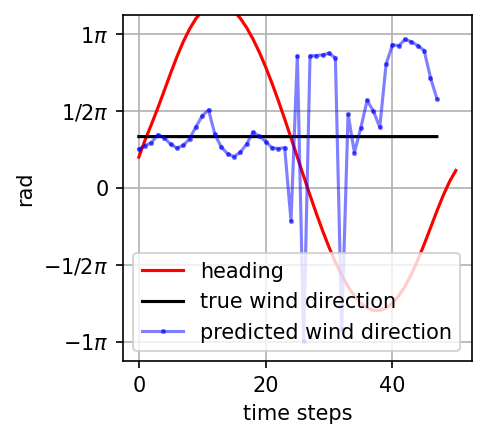

In [412]:
fig, ax = plt.subplots(1, 1, figsize=(3, 3), dpi=150)

ax.plot(mpc.sim_data_df.phi, 'r', label='heading')
ax.plot(zeta_true, 'k', label='true wind direction', markersize=3)
ax.plot(zeta_nn, '.-', label='predicted wind direction',  markersize=3, alpha=0.5, color='blue')

ff.pi_yaxis(ax)
ax.grid()
ax.legend()

ax.set_xlabel('time steps')
ax.set_ylabel('rad')